<a href="https://colab.research.google.com/github/ThomasLane1820/Prediction-of-Product-Sales/blob/main/Production_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales
- Author: Thomas Lane


## Project overview

## Load and Inspect Data

### Imports

In [210]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
# Importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Info

In [211]:

fpath = '/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv'
df = pd.read_csv(fpath)

In [212]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


- There are 8,523 rows, and 12 columns. There are 7 categorical/string columns and 5 numerical columns.

In [214]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,"7,060.00","8,523.00","8,523.00","8,523.00","8,523.00"
mean,12.86,0.07,140.99,"1,997.83","2,181.29"
std,4.64,0.05,62.28,8.37,"1,706.50"
min,4.55,0.00,31.29,"1,985.00",33.29
25%,8.77,0.03,93.83,"1,987.00",834.25
50%,12.60,0.05,143.01,"1,999.00","1,794.33"
75%,16.85,0.09,185.64,"2,004.00","3,101.30"
max,21.35,0.33,266.89,"2,009.00","13,086.96"


## Data Cleaning

#### Duplicated Data

In [215]:
# Creating a filter that identifies duplicated rows.
duplicated_rows = df.duplicated()
# finding the sum of duplicated rows.
duplicated_rows.sum()

0

- There are no duplicated rows.
- Now it's time to check and see if there are any missing values.

#### Missing Values

In [216]:
# getting the number of null values in each column and saving it as a variable.
null_values = df.isna().sum()
null_values

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- The only columns that have nulls are "Item_weight" abd "Outlet_Size", and they each have over 1000 nulls. I'll address this by using placeholder values.

In [217]:
# Replacing the missing "Item_Weight" values with the placeholder value of (-1).
df["Item_Weight"] = df["Item_Weight"].fillna(-1)

In [218]:
# Replacing the missing "Outlet_Size" values with the placeholder value of "MISSING".
df['Outlet_Size'] = df["Outlet_Size"].fillna("MISSING")

In [219]:
# Verifying that all missing values were properly replaced.
null_values = df.isna().sum()
null_values

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

- There are no more missing null values in our data set.
- Now to cehck and see if there are any inconsistent data categories.

#### Data Inconsistencies

##### Categorical inconsistencies

In [220]:
# Saving a list of object columns
string_cols = df.select_dtypes('object').columns
string_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [221]:
# Checking the number of unique values in each object column.
df[string_cols].nunique()

Item_Identifier         1559
Item_Fat_Content           5
Item_Type                 16
Outlet_Identifier         10
Outlet_Size                4
Outlet_Location_Type       3
Outlet_Type                4
dtype: int64

In [222]:
# Checking the percentage of unique values to ensure nothing is too our of the ordinary
df[string_cols].nunique() / len(df) * 100

Item_Identifier        18.29
Item_Fat_Content        0.06
Item_Type               0.19
Outlet_Identifier       0.12
Outlet_Size             0.05
Outlet_Location_Type    0.04
Outlet_Type             0.05
dtype: float64

In [223]:

# loop through the list of string columns
for col in string_cols:
  # print the value counts for the column
  print(f'Value counts for {col}')
  print(df[col].value_counts())
  # Printing an empty line for readability
  print('\n')

Value counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930


- Using this method we can see a there are a few inconsistencies in Item_Fat_Content. Where Low fat, LF, low fat, reg, Regular can be simplified
- Along with weird phrasing in Outlet_Size where it goes from Small, Medium, and High.

In [224]:
# Replacing "LF" and "low fat" with "Low Fat" in Item_Fat_Content.
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat',
                                                         'low fat': 'Low Fat'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    2889
reg         117
Name: Item_Fat_Content, dtype: int64

In [225]:
# Replacing "reg" with "Regular".
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'reg': 'Regular'})
# Ensuring that the oddities are resovled
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [226]:
# Replacing "High" with "Large" in Outlet_Size for sizing terminology consistency
df['Outlet_Size'] = df['Outlet_Size'].replace({'High': 'Large'})
# Ensuring that the oddities are resovled
df['Outlet_Size'].value_counts()

Medium     2793
MISSING    2410
Small      2388
Large       932
Name: Outlet_Size, dtype: int64

- Now all inconsistencies in Item_Fat_Content are resolved.
- While there were no clear oddities in Outlet_Size and the "fix" was largely preferential, that column is also resolved.

- The "Item_Identifier" Has a lot of repeat values, I want to verify that these are intended.

In [227]:
# Verifying that the duplicate "Item_Identifier" values are unique rather than near copies
df[df['Item_Identifier'] == 'FDW13']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
256,FDW13,8.50,Low Fat,0.10,Canned,51.13,OUT017,2007,MISSING,Tier 2,Supermarket Type1,259.66
1141,FDW13,8.50,Low Fat,0.10,Canned,51.13,OUT035,2004,Small,Tier 2,Supermarket Type1,"1,350.24"
2190,FDW13,8.50,Low Fat,0.10,Canned,51.33,OUT018,2009,Medium,Tier 3,Supermarket Type2,934.78
3928,FDW13,-1.00,Low Fat,0.10,Canned,52.73,OUT027,1985,Medium,Tier 3,Supermarket Type3,"2,492.76"
3978,FDW13,8.50,Low Fat,0.10,Canned,51.53,OUT049,1999,Medium,Tier 1,Supermarket Type1,882.85
6499,FDW13,8.50,Low Fat,0.10,Canned,50.33,OUT045,2002,MISSING,Tier 2,Supermarket Type1,675.12
6587,FDW13,8.50,Low Fat,0.16,Canned,51.33,OUT010,1998,MISSING,Tier 3,Grocery Store,311.59
7029,FDW13,8.50,Low Fat,0.10,Canned,50.53,OUT013,1987,Large,Tier 3,Supermarket Type1,882.85
8025,FDW13,-1.00,Low Fat,0.17,Canned,50.53,OUT019,1985,Small,Tier 1,Grocery Store,207.73
8032,FDW13,8.50,Low Fat,0.10,Canned,52.53,OUT046,1997,Small,Tier 1,Supermarket Type1,"1,194.45"


- The FDW13 item does have a lot of repeats in the data set, but each item is from a unique store so I will assume it's not an error.
- Now it's time to check for any numerical inconsistencies.

##### Numerical Inconsistencies

In [228]:
# Saving a list of numerical columns
num_cols = df.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [229]:
# Using .describe() to view the statistics of our data
for col in num_cols:
  # print the description of each column
  print(f'Value counts for {col}')
  print(df[col].describe())
  # Print an empty line for readability
  print('\n')

Value counts for Item_Weight
count   8,523.00
mean       10.48
std         6.72
min        -1.00
25%         6.65
50%        11.00
75%        16.00
max        21.35
Name: Item_Weight, dtype: float64


Value counts for Item_Visibility
count   8,523.00
mean        0.07
std         0.05
min         0.00
25%         0.03
50%         0.05
75%         0.09
max         0.33
Name: Item_Visibility, dtype: float64


Value counts for Item_MRP
count   8,523.00
mean      140.99
std        62.28
min        31.29
25%        93.83
50%       143.01
75%       185.64
max       266.89
Name: Item_MRP, dtype: float64


Value counts for Outlet_Establishment_Year
count   8,523.00
mean    1,997.83
std         8.37
min     1,985.00
25%     1,987.00
50%     1,999.00
75%     2,004.00
max     2,009.00
Name: Outlet_Establishment_Year, dtype: float64


Value counts for Item_Outlet_Sales
count    8,523.00
mean     2,181.29
std      1,706.50
min         33.29
25%        834.25
50%      1,794.33
75%      3,101.30
max  

- Upon first inspection the numerical columns seems to not have any apparent inconsistencies or oddities, other than Item_Weight which we replaced the missing values with -1.
- If we look back at the "Loading Data" section we find that the min for Item_Weight was 4.555.

## Exploratory Data analysis

### Visualization of data

#### Histograms

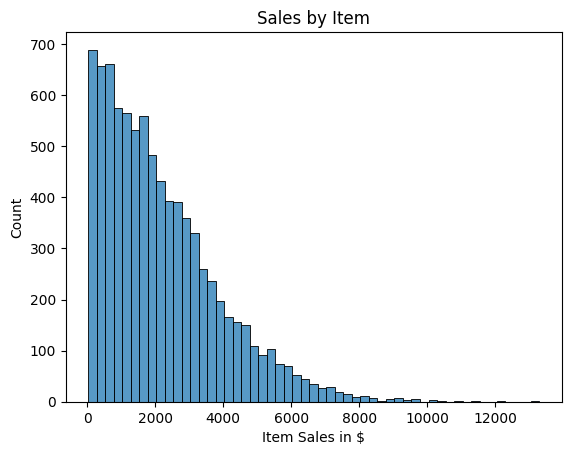

In [230]:
# Creating a histogram displaying the sales per item.
ax = sns.histplot(data = df, x = 'Item_Outlet_Sales', binwidth = 250)
ax.ticklabel_format(style = 'plain')
ax.set_title('Sales by Item');
ax.set_xlabel('Item Sales in $');

- This histogram shows that there are over 1,500 items that generate less than $500 in sales.
- We can potentially take a closer look into these items to see why that may be the case.

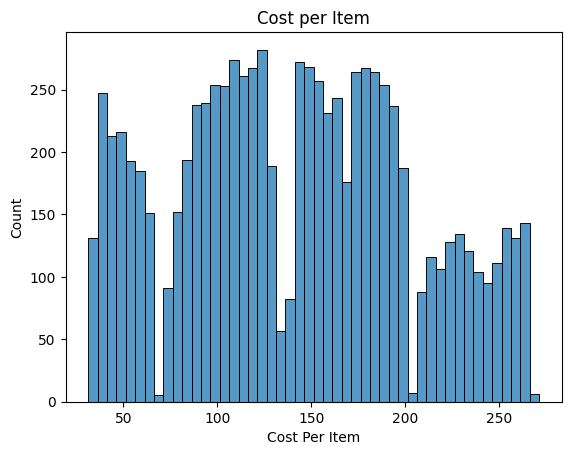

In [231]:
# Creating a histogram displaying the cost per item.
ax = sns.histplot(data = df, x = 'Item_MRP', binwidth = 5)
ax.ticklabel_format(style = 'plain')
ax.set_title('Cost per Item');
ax.set_xlabel('Cost Per Item');

#### Boxplots

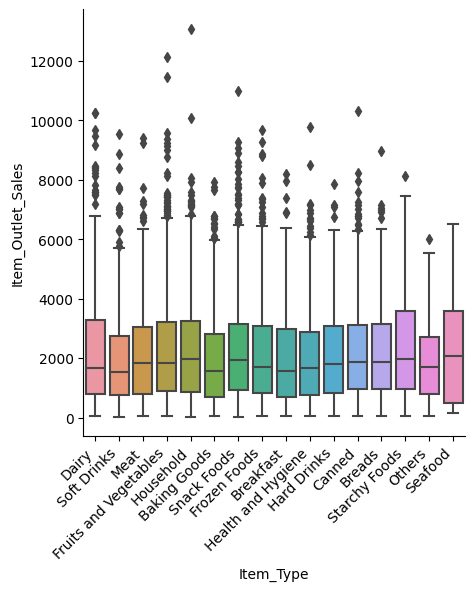

In [232]:
# Plotting a boxplot representing total sales by Item_Type
ax = sns.catplot(data = df, x = 'Item_Type', y = 'Item_Outlet_Sales',
                 hue = 'Item_Type',
                 kind = 'box', dodge = False)
ax.set_xticklabels( rotation = 45, ha = 'right');

- From first inspection it appears that Seafood is the most consistent seller. As it has the highest minimum, median value, potentially the highest 75th percentile.
- We can take a closer look into the Others and baking foods item types to see if we can find out why they may be falling behind.

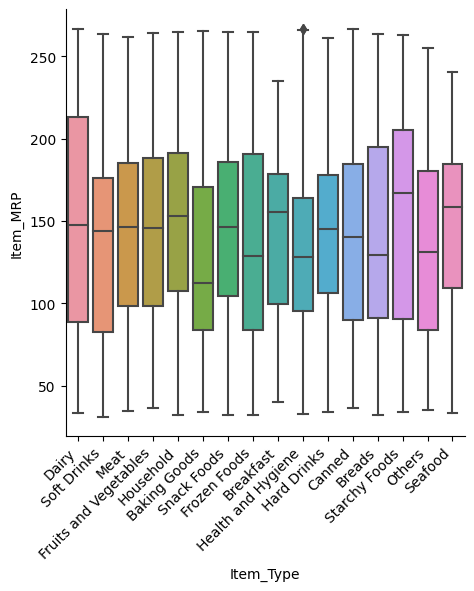

In [233]:
ax = sns.catplot(data = df, x = 'Item_Type', y = 'Item_MRP',
                 hue = 'Item_Type',
                 kind = 'box', dodge = False)
ax.set_xticklabels( rotation = 45, ha = 'right');

#### Countplots

In [234]:
item_type_counts = df['Item_Type'].value_counts()


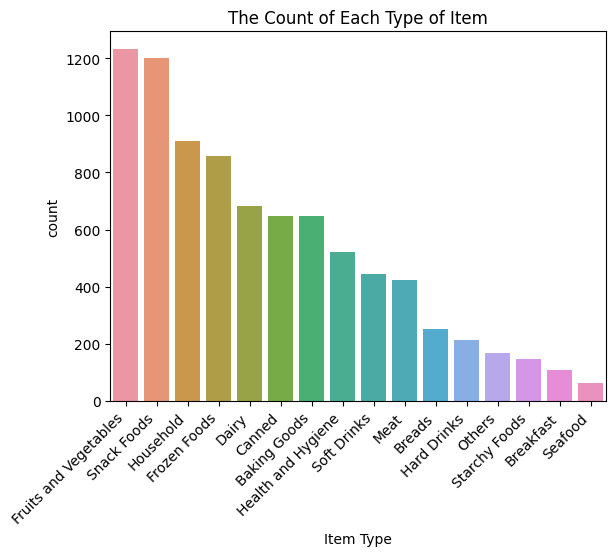

In [235]:
ax = sns.countplot(data = df, x = 'Item_Type',
                   order = item_type_counts.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right');
ax.set_xlabel('Item Type');
ax.set_title('The Count of Each Type of Item');

- Knowing how well seafood performs overall, we might want to look into upping the seafood inventory at certain locations.
- I would also reccomend upping the Starchy food inventory due to it's consistentcy.
- The top three item groups all perform very well.

#### Heatmaps

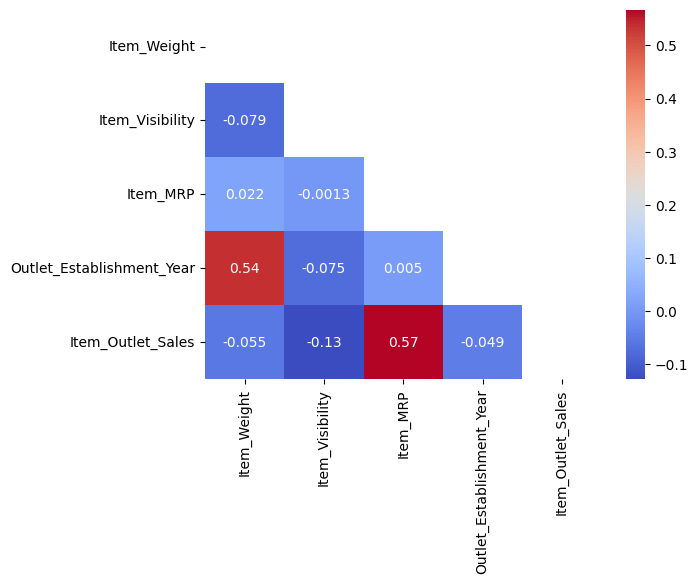

In [236]:
# Creating a variable that contains the correlations.
corr = df.corr(numeric_only = True)
# The mask variable allows us to mask half of the heatmap.
mask = np.triu(np.ones_like(corr))
# The heatmap.
sns.heatmap(corr, cmap = 'coolwarm', annot = True, mask = mask);

- There is only a moderate correlation between Item_Weight and Outlet_Establishment_Year, and Item_Outlet_Sales with Item_MRP.
- I can't imagine the correlation between between Item_Weight and Outlet_Establishment_Year means all to much but we will look further into it.

#### Visualizing correlations



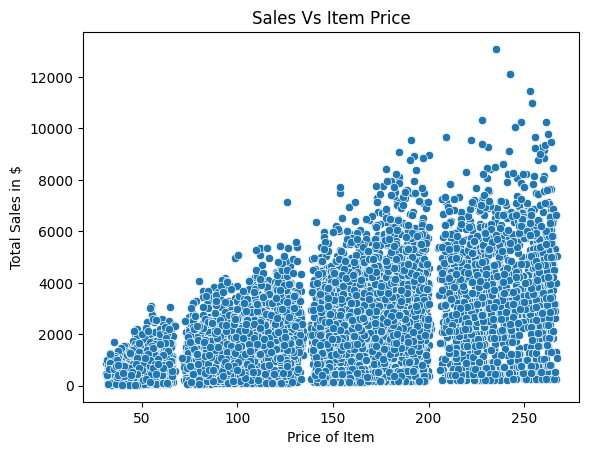

In [237]:
ax = sns.scatterplot(data = df, x = 'Item_MRP', y = 'Item_Outlet_Sales')
ax.set_title('Sales Vs Item Price');
ax.set_ylabel('Total Sales in $');
ax.set_xlabel('Price of Item');

- Visualizing the correlation found between "Item_MRP" and "Item_Outlet_Sales" appears to show that the higher the price of an item the higher the item's poetential sales.
- We might be able to leverage this by adding more high quality, high price items to our stock.

In [238]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,MISSING,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,Large,Tier 3,Supermarket Type1,994.71


## Feature inspection

### Replacing all placeholder values with null values.

I'll replace all the placeholder values I added in Outlet_Size and Item_Weight with null values.

In [239]:
# Creating a filter that contains every "-1" placeholder in the Item_Weight column
filter_neg_weight = df['Item_Weight'] < 0
filter_neg_weight.sum()

1463

In [240]:
# Replacing negative values with null values
df.loc[filter_neg_weight,'Item_Weight'] = np.nan
# Confirming the change
filter_neg_weight = df['Item_Weight'] < 0
filter_neg_weight.sum()

0

In [241]:
# Creating a filter for all placeholder values in Outlet_Size
filter_missing_size = df['Outlet_Size'] == 'MISSING'
filter_missing_size.sum()

2410

In [242]:
# Replacing 'MISSING' values with null values
df.loc[filter_missing_size,'Outlet_Size'] = np.nan
# Confirming the change
filter_missing_size = df['Outlet_Size'] == 'MISSING'
filter_missing_size.sum()

0

- Now that all the placeholders I've added have been taken care of I'll move onto feature insepction.

### Data Dictionary

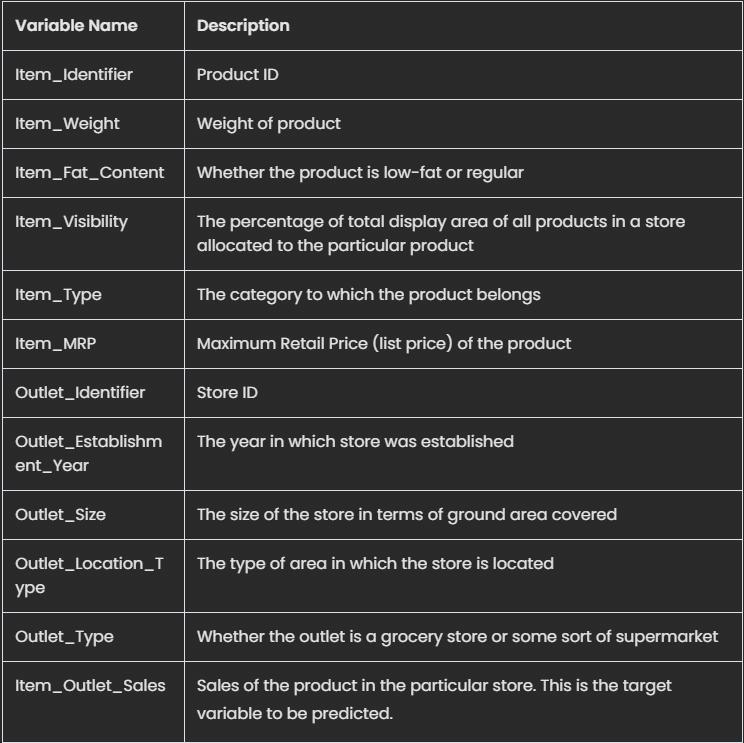

### Univariate Visualization

In [243]:
# Creating an order in which the data is displayed.
uni_order = {'MISSING', 'Medium', 'Large', 'Small'}

In [244]:
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order =uni_order):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold');

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

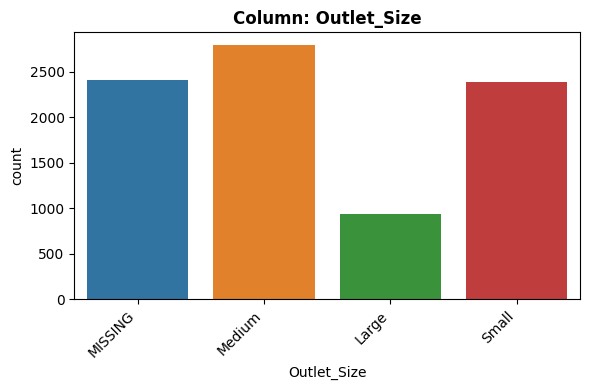

- NaN's Found: 2410 (28.28%)
- Unique Values: 4
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Outlet_Size'}, xlabel='Outlet_Size', ylabel='count'>)

In [245]:
explore_categorical(df , 'Outlet_Size')

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This is a ordinal feature
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 2410 null values.
  - 28.28% of the values are null
  - We can use machine learning to look into the statistics of each missing store size and infer what the size may be.
- Is the feature constant or quasi-constant?
  - It is neither constant or quasi-constant
- What is the cardinality? Is it high (>10)?
  - The cardinality is not high, being only 4.
- Would we know this feature before the target is determined?
  - Yes
- Is there a business case/understanding reason to exclude based on our business case?
  - No, the size of the outlet is important information.

### Multivariate Visualizaiton

In [246]:
# Creating an order in which the data is displayed.
multi_order = {'MISSING', 'Large', 'Medium', 'Small'}

In [247]:
def plot_categorical_vs_target(df, x, y='Item_Outlet_Sales',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = multi_order):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Size vs. Item_Outlet_Sales'}, xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>)

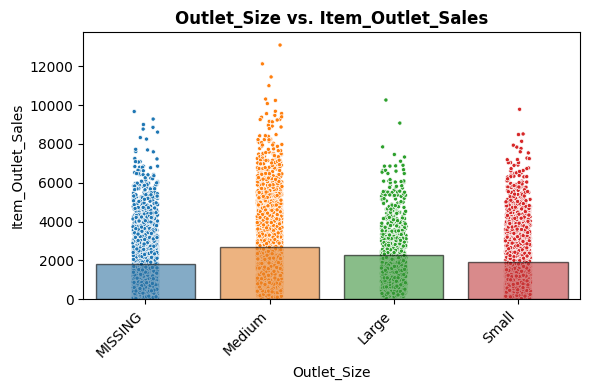

In [248]:
plot_categorical_vs_target(df, 'Outlet_Size')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - Yes, I would expect the outlet size to impact sales in one way or another.
- Does this feature appear to be a predictor of the target?
  - This feature seems to reveal that medium outlets are performing better than both large and small outlets. This could mean it's more worth it to invest in a medium sized outlet over a large outlet.

# Machine Learning preparation

## Loading and data inspection

In [249]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [250]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [251]:
fpath = '/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv'
df2 = pd.read_csv(fpath)

In [252]:
df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


In [253]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [254]:
df2.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Cleaning Data for Machine Learning

### Duplicated Data

In [255]:
# Creating a filter that identifies duplicated rows.
duplicated_rows = df2.duplicated()
# finding the sum of duplicated rows.
duplicated_rows.sum()

0

- There are no duplicated rows.

### Data Inconsistencies

#### Categorical inconsistencies

In [256]:
# Saving a list of object columns
string_cols = df2.select_dtypes('object').columns
string_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [257]:
# Checking the number of unique values in each object column.
df2[string_cols].nunique()

Item_Identifier         1559
Item_Fat_Content           5
Item_Type                 16
Outlet_Identifier         10
Outlet_Size                3
Outlet_Location_Type       3
Outlet_Type                4
dtype: int64

In [258]:
# Checking the percentage of unique values to ensure nothing is too our of the ordinary
df2[string_cols].nunique() / len(df) * 100

Item_Identifier        18.29
Item_Fat_Content        0.06
Item_Type               0.19
Outlet_Identifier       0.12
Outlet_Size             0.04
Outlet_Location_Type    0.04
Outlet_Type             0.05
dtype: float64

In [259]:
# loop through the list of string columns
for col in string_cols:
  # print the value counts for the column
  print(f'Value counts for {col}')
  print(df2[col].value_counts())
  # Printing an empty line for readability
  print('\n')

Value counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930


- Using this method we can see a there are a few inconsistencies in Item_Fat_Content. Where Low fat, LF, low fat, reg, Regular can be simplified
- Along with weird phrasing in Outlet_Size where it goes from Small, Medium, and High.

In [260]:
# Replacing "LF" and "low fat" with "Low Fat" in Item_Fat_Content.
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].replace({'LF': 'Low Fat',
                                                         'low fat': 'Low Fat'})
df2['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    2889
reg         117
Name: Item_Fat_Content, dtype: int64

In [261]:
# Replacing "reg" with "Regular".
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].replace({'reg': 'Regular'})
# Ensuring that the oddities are resovled
df2['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [262]:
# Replacing "High" with "Large" in Outlet_Size for sizing terminology consistency
df2['Outlet_Size'] = df2['Outlet_Size'].replace({'High': 'Large'})
# Ensuring that the oddities are resovled
df2['Outlet_Size'].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

- Now all inconsistencies in Item_Fat_Content are resolved.
- While there were no clear oddities in Outlet_Size and the "fix" was largely preferential, that column is also resolved.

#### Numerical Inconsistencies

In [263]:
# Saving a list of numerical columns
num_cols = df2.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [264]:
# Using .describe() to view the statistics of our data
for col in num_cols:
  # print the description of each column
  print(f'Value counts for {col}')
  print(df2[col].describe())
  # Print an empty line for readability
  print('\n')

Value counts for Item_Weight
count   7,060.00
mean       12.86
std         4.64
min         4.55
25%         8.77
50%        12.60
75%        16.85
max        21.35
Name: Item_Weight, dtype: float64


Value counts for Item_Visibility
count   8,523.00
mean        0.07
std         0.05
min         0.00
25%         0.03
50%         0.05
75%         0.09
max         0.33
Name: Item_Visibility, dtype: float64


Value counts for Item_MRP
count   8,523.00
mean      140.99
std        62.28
min        31.29
25%        93.83
50%       143.01
75%       185.64
max       266.89
Name: Item_MRP, dtype: float64


Value counts for Outlet_Establishment_Year
count   8,523.00
mean    1,997.83
std         8.37
min     1,985.00
25%     1,987.00
50%     1,999.00
75%     2,004.00
max     2,009.00
Name: Outlet_Establishment_Year, dtype: float64


Value counts for Item_Outlet_Sales
count    8,523.00
mean     2,181.29
std      1,706.50
min         33.29
25%        834.25
50%      1,794.33
75%      3,101.30
max  

### Dropping columns with a large cardinality

- The "Item_Identifier" has a very large cardinality. This will create a lot of noise when it comes to machine learning. So we'll drop the column.

In [265]:
df2 = df2.drop(columns = 'Item_Identifier')
df2.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,Large,Tier 3,Supermarket Type1,994.71


## Creating the the training and test splits

In [266]:
# Defining the target as Item_Outlet_Sales
target = df2['Item_Outlet_Sales']
# Defining y as our target
y = target
# Defining X as all relevant features in predicting our target
X = df2.drop(columns = 'Item_Outlet_Sales')

In [267]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Preparing numeric values for ColumnTransformer

### Numeric Pipeline

In [268]:
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
num_pipe

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

### Numeric Tuple

In [269]:
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

## Preparing Oridnal values for ColumnTransformer

### Ordinal Pipeline

In [270]:
# Save list of column names
ord_cols = ['Outlet_Size']
print("Ordinal Columns:", ord_cols)
# Create imputer for ordinal data
impute_most_freq = SimpleImputer(strategy = 'most_frequent')
## Making the OrdinalEncoder
# Specifying order of categories for our  Ordinal Qual/Cond Columms
outlet_size_order = ['Small', 'Medium', 'Large']
# Making the list of order lists for OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories = [outlet_size_order])
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()
## Making an ord_pipe
ord_pipe = make_pipeline(impute_most_freq, ordinal_encoder, scaler)
ord_pipe

Ordinal Columns: ['Outlet_Size']


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])),
                ('standardscaler', StandardScaler())])

### Ordinal Tuple

In [271]:
# Making an ordinal_tuple for ColumnTransformer
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

## Preparing Categorical values for ColumnTransformer

### Categorical Pipeline

In [272]:
# Save list of column names
ohe_cols = X_train.select_dtypes('object').drop(columns = ord_cols).columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy = 'constant', fill_value = "MISSING",
                         )
ohe_encoder = OneHotEncoder(drop = 'first', sparse= False)
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe

OneHotEncoder Columns: Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder', OneHotEncoder(drop='first', sparse=False))])

### Categorical Tuple

In [273]:
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='MISSING', strategy='constant')),
                 ('onehotencoder', OneHotEncoder(drop='first', sparse=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'))

## Instantiating and Fitting the ColumnTransformer

In [274]:
# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ohe_tuple, ord_tuple],
                                    verbose_feature_names_out=False)
# Fit on training data
col_transformer.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 (...
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'Large']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size'])],
                  verbose_feature_names_out=False)

## Transforming the training and test data

In [275]:
# Transform the training data
X_train_processed = col_transformer.transform(X_train)
# Transform the testing data
X_test_processed = col_transformer.transform(X_test)
# run get_feature_names_out
feature_names = col_transformer.get_feature_names_out()
X_train_tf = pd.DataFrame(col_transformer.transform(X_train),
                          columns = feature_names, index = X_train.index)

X_test_tf = pd.DataFrame(col_transformer.transform(X_test),
                          columns = feature_names, index = X_test.index)
X_test_tf.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
7503,0.34,-0.78,-1.00,-1.29,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.96
2957,-1.17,0.10,-1.59,-0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.38
7031,0.39,-0.48,-1.60,0.14,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.29


### Checking the data in the transformed data

In [276]:
# Viewing the processed training data
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
4776,0.83,-0.71,1.83,1.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.29
7510,0.57,-1.29,0.60,1.33,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.29
5828,-0.12,1.81,0.24,0.14,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.29
5327,-1.16,-1.00,-0.95,0.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,-1.38
4810,1.54,-0.97,-0.34,0.49,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.29


In [277]:
# Viewing the processed testing data
X_test_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
7503,0.34,-0.78,-1.00,-1.29,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.96
2957,-1.17,0.10,-1.59,-0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.38
7031,0.39,-0.48,-1.60,0.14,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.29
1084,-0.05,-0.42,0.51,-1.53,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.29
856,-0.63,-1.05,0.89,0.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,-1.38


### Verifying everything was scaled properly

In [278]:
# Verifying all the data types
X_train_processed.dtypes

Item_Weight                        float64
Item_Visibility                    float64
Item_MRP                           float64
Outlet_Establishment_Year          float64
Item_Fat_Content_Regular           float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              float64
Item_Type_Starchy Foods            float64
Outlet_Identifier_OUT013           float64
Outlet_Identifier_OUT017           float64
Outlet_Identifier_OUT018           float64
Outlet_Iden

In [279]:
# Verfiying all data has been scaled
X_train_processed.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
count,"6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00","6,392.00"
mean,-0.00,-0.00,0.00,-0.00,0.35,0.03,0.01,0.08,0.08,0.10,0.15,0.03,0.06,0.11,0.05,0.02,0.01,0.14,0.05,0.02,0.11,0.11,0.11,0.06,0.11,0.11,0.11,0.11,0.11,0.33,0.40,0.65,0.11,0.11,0.00
std,1.00,1.00,1.00,1.00,0.48,0.16,0.11,0.26,0.27,0.30,0.36,0.16,0.24,0.31,0.21,0.14,0.08,0.35,0.22,0.14,0.31,0.31,0.31,0.24,0.32,0.31,0.31,0.31,0.31,0.47,0.49,0.48,0.31,0.32,1.00
min,-1.97,-1.29,-1.77,-1.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.38
25%,-0.80,-0.76,-0.76,-1.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.38
50%,-0.05,-0.23,0.03,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29
75%,0.77,0.56,0.72,0.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.29
max,2.01,5.13,1.99,1.33,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.96


- every data type is float64 numeric data type.
- The means and standard deviations are both zero and one respectively.
- I can confidently say the training data was scaled properly

In [280]:
# Verifying all the data types
X_test_processed.dtypes

Item_Weight                        float64
Item_Visibility                    float64
Item_MRP                           float64
Outlet_Establishment_Year          float64
Item_Fat_Content_Regular           float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              float64
Item_Type_Starchy Foods            float64
Outlet_Identifier_OUT013           float64
Outlet_Identifier_OUT017           float64
Outlet_Identifier_OUT018           float64
Outlet_Iden

In [281]:
# Verfiying all data has been scaled
X_test_processed.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
count,"2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00","2,131.00"
mean,-0.04,0.01,-0.06,-0.01,0.35,0.04,0.01,0.08,0.08,0.11,0.13,0.02,0.06,0.10,0.06,0.02,0.01,0.14,0.05,0.01,0.11,0.11,0.11,0.07,0.10,0.10,0.11,0.11,0.12,0.32,0.38,0.66,0.11,0.10,0.01
std,1.01,1.04,0.98,0.99,0.48,0.19,0.11,0.27,0.27,0.31,0.34,0.14,0.24,0.30,0.23,0.13,0.10,0.34,0.23,0.11,0.32,0.31,0.31,0.25,0.30,0.30,0.31,0.31,0.32,0.47,0.49,0.47,0.31,0.30,1.01
min,-1.96,-1.29,-1.75,-1.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.38
25%,-0.88,-0.76,-0.78,-1.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.38
50%,-0.05,-0.24,-0.15,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29
75%,0.74,0.56,0.64,0.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.29
max,2.01,4.79,1.99,1.33,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.96


- every data type is float64 numeric data type.
- The means and standard deviations are both nearly zero and one respectively.
- I can confidently say the testing data was scaled properly

## CRISP-DM Phase 4 - Modeling

### Functions for Modeling

In [282]:
## SK Learn Display
set_config(display='diagram')

## Transformers output as a Pandas Dataframe
set_config(transform_output='pandas')

In [283]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [284]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics
def evaluate_regression(pipe, X_train, y_train, X_test, y_test,
                       model_name='Regression Model'):

  """Takes a regression model, training features and target and testing features and target.
  Returns a dataframe of regression metrics"""

  ## Predictions
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  metrics = ['train_MAE','test_MAE',
             'train_RMSE', 'test_RMSE',
             'train_R2', 'test_R2']

  ## Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),4)

  ## Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),4)

  ## Output Dataframe
  scores = pd.DataFrame(columns=metrics, index=[model_name])
  scores.loc[model_name, :] = [train_mae, test_mae,
                              train_rmse, test_rmse,
                              train_r2, test_r2]

  return scores

In [285]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False,
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
           ylabel='Feature Names',
           title=title)
    ax.axvline(0, color='k')

    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

1. Your first task is to build a linear regression model to predict sales.

- Build a linear regression model.
- Use the custom evaluation function to get the metrics for your model (on training and test data).
- Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

### Linear Regression Model

In [286]:
# Fit the model on the training data
lin_reg = LinearRegression()
lin_reg.fit(X_train_processed, y_train)

LinearRegression()

In [287]:
# Get predictions for the training data
y_predictions_train = lin_reg.predict(X_train_processed)
# Get predictions for the testing data
y_predictions_test = lin_reg.predict(X_test_processed)

In [288]:
lin_reg_scores = evaluate_regression(lin_reg, X_train_processed, y_train, X_test_processed,
                    y_test, model_name='Linear Regression')
lin_reg_scores

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Linear Regression,847.15,804.15,"1,139.10","1,092.87",0.56,0.57


- While the R^2 values are within a percent of one another, the values are only .56.
- The model appears to be underfit due to the very low variance and the high bias in the model.

### Visualizing Coefficients

In [301]:
# Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
coeffs['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                                           -8.02
Item_Visibility                                      -21.76
Item_MRP                                             984.64
Outlet_Establishment_Year            816,782,291,984,896.25
Item_Fat_Content_Regular                              62.70
Item_Type_Breads                                     -29.01
Item_Type_Breakfast                                   44.94
Item_Type_Canned                                      26.97
Item_Type_Dairy                                     -106.62
Item_Type_Frozen Foods                                -1.79
Item_Type_Fruits and Vegetables                       45.93
Item_Type_Hard Drinks                                 13.82
Item_Type_Health and Hygiene                          27.57
Item_Type_Household                                    5.40
Item_Type_Meat                                       -11.95
Item_Type_Others                                     -26.75
Item_Type_Seafood                       

- I tried many many things and couldn't figure out how to fix the categorical columns.
- Even the oridnal columns aren't becoming coefficients correctly.


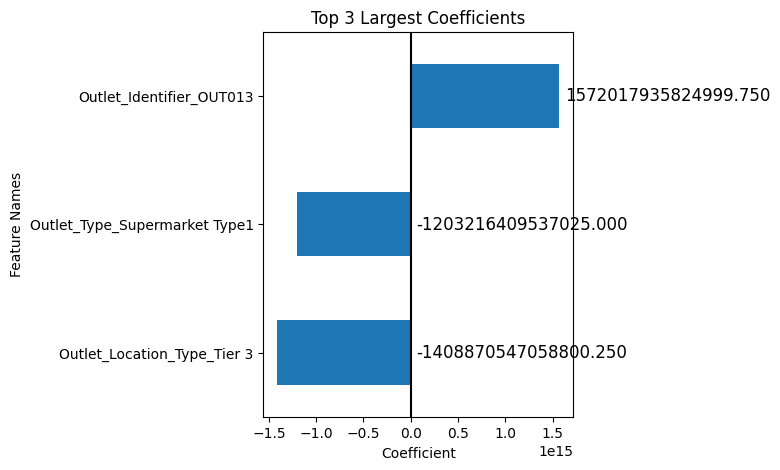

In [290]:
plot_coeffs(coeffs,top_n=3,intercept=False,annotate=True);

- Although the data isn't quite calibrated properly, the three most impactful features are:
  - Outlet_Identifier_OUT013
  - Outlet_Type_Supermarket Type 1
  - Outlet_Location_Type_Tier 3

### Random Forest Model

In [291]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)
# Model Pipeline
rf_pipe = make_pipeline(col_transformer, rf)

In [292]:
# Fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_va...
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'Large']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [293]:
# Use custom function to evaluate default model
def_rf_scores = evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test, model_name = 'Default Random Tree')
def_rf_scores

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Default Random Tree,297.24,774.82,428.76,"1,110.92",0.94,0.55


- This model is clearly signiicantly overfit.
- The training R^2 value is .9384, while the test value is only .5604.
- Variance this high can be resolved by adjusting the hyperparameters of our model to resolve the overfitting and reduce variance.

3. Use GridSearchCV to tune at least two hyperparameters for a Random Forest model.

- After determining the best parameters from your GridSearch, fit and evaluate a final best model on the entire training set (no folds).
- Compare your tuned model to your default Random Forest: did the performance improve

## Inspecting 5 most important features

In [294]:
# Saving the feature importances
feature_importance = pd.Series(rf.feature_importances_, index=feature_names,
                        name='Feature Importances')
feature_importance.head()

Item_Weight                 0.06
Item_Visibility             0.10
Item_MRP                    0.44
Outlet_Establishment_Year   0.04
Item_Fat_Content_Regular    0.01
Name: Feature Importances, dtype: float64

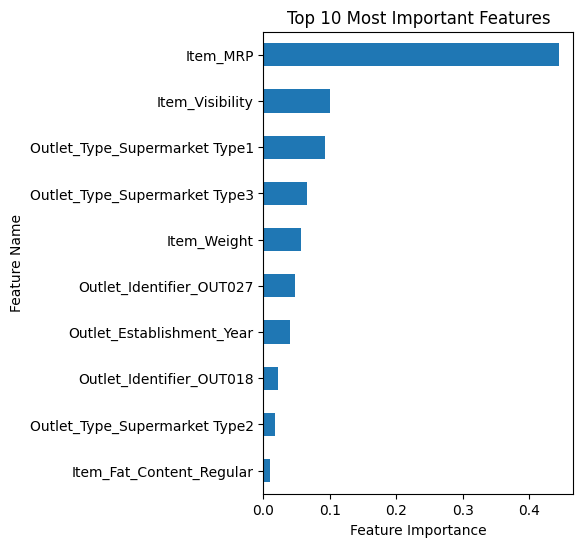

In [295]:
# plotting top 10 importances
ax = feature_importance.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 10 Most Important Features');

- The five most important features are:
  - Item_MRP
  - Item_Visibility
  - Outlet_Type_Supermarket Type 1
  - Outlet_Type_Supermarket Type3
  - Item_weight

### Using GridSearchCV to tune Random Forest model

In [296]:
# Parameters for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='MISSING',
                                                                   strategy='constant')),
                                                    (...
                                    Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Ide

In [297]:
# Define param grid with options to try
params = {'randomforestregressor__max_depth': [3, 5, 8],
          'randomforestregressor__n_estimators':[1500, 2000, 2500],
          'randomforestregressor__min_samples_leaf':[2, 3],
          }
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)
# Obtain best parameters
gridsearch.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


KeyboardInterrupt: ignored

In [ ]:
# Define and refit best model
best_rf = gridsearch.best_estimator_
best_rf_scores = evaluate_regression(best_rf, X_train, y_train, X_test, y_test, model_name = 'Tuned Random Tree Model')
best_rf_scores

- After tuning the model the performance improved significantly.
-

## CRISP-DM Phase 5 - Evaluation





4. You now have tried several different models on your data set. You need to determine which model to implement.

- Overall, which model do you recommend?
- Justify your recommendation.
- In a Markdown cell:
  - Interpret your model's performance based on R-squared in a way that your non-technical stakeholder can understand.
  - Select another regression metric (RMSE/MAE/MSE) to express the performance of your model to your stakeholder.
  - Include why you selected this metric to explain to your stakeholder.
  - Compare the training vs. test scores and answer the question: to what extent is this model overfit/underfit?

In [ ]:
# Grouping each model
scores_df = pd.concat([best_rf_scores, def_rf_scores, lin_reg_scores])
# Ordering by highest test_R2
scores_df.sort_values(by='test_R2')

In [ ]:
# Ordering by
scores_df.sort_values(by='test_RMSE')

- The model I recommend most would be the best_rf_scores, optimized random tree model.

Analyzing R^2
- That model had the lowest variance, while also having the lowest bias.
- The optimized random tree model had a test R^2 score of .6033, much higher than that of the other models.
- The R^2 of .6, means that the prediction will be roughly 40% off.

Analyzing RMSE
- We can see that the RMSE/Root Mean Squared Error, is also the lowest for our tuned random tree.
- The RMSE accentuates larger errors more than small errors. Having a smaller RMSE typically means the models errors won't be as extreme.

Is the Tuned Random Tree over/under fit?
- The model is not very overfit by any means, the R^2s for the test and training data aer within 1% of each other.
- Comparing MAE and RMSE will show that those values are also similar across training and testing data.
- Now the model can be considered underfit as the bias still seems fairly high.
- This could be due to a few reasons:
  - Not using a complex enough model.
  - 'Bad' data or data that still contains too much noise.
  - Using only the most relevant features to our target.

# (Core) Project 1 - Part 8
- LinearRegression
  - Extract and visualize the coefficients that your model determined.
  - Select the top 3 most impactful features and interpret their coefficients in plain English.
  - Save your figure as a .png file to upload to your README on GitHub  (you will need this for the final piece of this assignment - Update Your README).
- Tree-Based Model
  - Extract and visualize the feature importances that your best model determined.
  - Identify the top 5 most important features.
  - Save your figure as a .png file to upload to your README on GitHub (you will need this for the final piece of this assignment - Update Your README).
- Update your README
  - Insert your exported figures from above into your README file. You should have the following:
  - Your LinearRegression coefficients plot.
  - Your interpretation of your coefficients.
  - Your tree-based model's feature importances.
  - Your interpretation of your feature importance.
  - Add final recommendations to your stakeholder.

# TO DO
- Complete Feature inspection
- Item Identifier
  - FD = food
  - DR = drink
  - NC = Non-Consumable
- NC Fat Content
- Target Encoding
- Model Stacking
- Spell Check -
- Outlet_Location_Type data type(?)